# Preparação do notebook 

Importando as bibliotecas

In [68]:
import pandas as pd
import numpy as np 
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.express as px

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_samples, silhouette_score

In [69]:
# Definir opções do notebook

pd.set_option('display.precision', 2)
pd.options.display.max_columns = 30

import warnings
warnings.filterwarnings("ignore")

## Preparação dos dados

exploração inicial dos dados.

In [70]:
# Importando os dados como um DataFrame e verificando as primeiras 5 linhas

df = pd.read_csv('./nbadataset/all_seasons.csv', index_col=0)
country_codes = pd.read_csv("./nbadataset/country_code.csv", index_col=0)

df.head()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,Randy Livingston,HOU,22.0,193.04,94.80,Louisiana State,USA,1996,2,42,64,3.9,1.5,2.4,0.3,0.04,0.07,0.17,0.49,0.25,1996-97
1,Gaylon Nickerson,WAS,28.0,190.50,86.18,Northwestern Oklahoma,USA,1994,2,34,4,3.8,1.3,0.3,8.9,0.03,0.11,0.17,0.50,0.04,1996-97
2,George Lynch,VAN,26.0,203.20,103.42,North Carolina,USA,1993,1,12,41,8.3,6.4,1.9,-8.2,0.11,0.18,0.17,0.51,0.12,1996-97
3,George McCloud,LAL,30.0,203.20,102.06,Florida State,USA,1989,1,7,64,10.2,2.8,1.7,-2.7,0.03,0.11,0.21,0.53,0.12,1996-97
4,George Zidek,DEN,23.0,213.36,119.75,UCLA,USA,1995,1,22,52,2.8,1.7,0.3,-14.1,0.10,0.17,0.20,0.50,0.06,1996-97


In [71]:
# Verificando os tipos de dados e se algum registro está faltando

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12844 entries, 0 to 12843
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player_name        12844 non-null  object 
 1   team_abbreviation  12844 non-null  object 
 2   age                12844 non-null  float64
 3   player_height      12844 non-null  float64
 4   player_weight      12844 non-null  float64
 5   college            10990 non-null  object 
 6   country            12844 non-null  object 
 7   draft_year         12844 non-null  object 
 8   draft_round        12844 non-null  object 
 9   draft_number       12844 non-null  object 
 10  gp                 12844 non-null  int64  
 11  pts                12844 non-null  float64
 12  reb                12844 non-null  float64
 13  ast                12844 non-null  float64
 14  net_rating         12844 non-null  float64
 15  oreb_pct           12844 non-null  float64
 16  dreb_pct           12844 no

Nenhum registro parece estar faltando. No entanto, vou fazer as seguintes edições

Criar coluna elaborada com lógica booleana 0/1

Converter a coluna draft_year em tipo inteiro

Converter coluna de temporada em tipo inteiro


In [72]:
df.describe()

,age,player_height,player_weight,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct
count,12844.00,12844.00,12844.00,12844.00,12844.00,12844.00,12844.00,12844.00,12844.00,12844.00,12844.00,12844.00,12844.00
mean,27.05,200.56,100.26,51.15,8.21,3.56,1.82,-2.23,0.05,0.14,0.18,0.51,0.13
std,4.34,9.11,12.43,25.08,6.02,2.48,1.80,12.67,0.04,0.06,0.05,0.10,0.09
min,18.00,160.02,60.33,1.00,0.00,0.00,0.00,-250.00,0.00,0.00,0.00,0.00,0.00
25%,24.00,193.04,90.72,31.00,3.60,1.80,0.60,-6.40,0.02,0.10,0.15,0.48,0.07
50%,26.00,200.66,99.79,57.00,6.70,3.00,1.20,-1.30,0.04,0.13,0.18,0.53,0.10
75%,30.00,208.28,108.86,73.00,11.50,4.70,2.40,3.20,0.08,0.18,0.22,0.56,0.18
max,44.00,231.14,163.29,85.00,36.10,16.30,11.70,300.00,1.00,1.00,1.00,1.50,1.00


Na primeira inspeção, destacam-se os seguintes itens:

O número máximo de GP (jogos disputados) é 85. A temporada da NBA é de 82 jogos, então os jogos extras terão que ser examinados.

Depois de examinar detalhadamente o conjunto de dados, encontramos 14 jogadores que registraram mais de 82 jogos disputados. Este tópico do Reddit (https://www.reddit.com/r/nba/comments/a8bsyn/in_the_200304_season_theo_ratliff_and_shareef/) sugere que o número é superior a 82 porque esses jogadores foram negociados no meio da temporada. Por este motivo, os registros não serão ajustados de forma alguma.

Os valores de net_rating estão entre -200 e 300. Isso parece estranho e a fórmula para calcular net_rating terá que ser revisada

Cálculo oficial do net_rating da NBA: NetRtg = 100((Pontos)/(POSS) - 100((Opp Points)/(Opp POSS))
Ainda não está claro como Bruce Bowen conseguiu obter uma classificação líquida de 300, mas no geral parece que os valores discrepantes são jogadores que tiveram contribuições estatísticas muito pequenas e geralmente jogaram apenas uma partida. Portanto, esses registros serão removidos.

In [73]:
categoricals = df.select_dtypes(exclude=[np.number])
categoricals.describe()

,player_name,team_abbreviation,college,country,draft_year,draft_round,draft_number,season
count,12844,12844,10990,12844,12844,12844,12844,12844
unique,2551,36,356,82,48,9,76,27
top,Vince Carter,CLE,Kentucky,USA,Undrafted,1,Undrafted,2021-22
freq,22,450,447,10721,2358,7351,2414,605


Na primeira inspeção, destacam-se os seguintes itens:

Existem apenas 2.235 jogadores ao longo de 24 temporadas. Isso ilustra o quão competitivo é chegar à NBA.

Existem 36 abreviações exclusivas de equipe. A liga em 2019 era composta por 30, então os 6 times extras terão que ser examinados.

As equipes extras estão extintas: Seattle SuperSonics, Charlotte Bobcats, etc.

O Draft da NBA de 2019 tem apenas 2 rodadas, então um número único de 8 rodadas parece interessante.

Acontece que historicamente o Draft teve muito mais rodadas (chegando a 21, na verdade). Somente em 1989 a NBA se contentou com o sistema de duas rodadas.

O oitavo valor exclusivo na coluna draft_round é a variável não elaborada.

Existem 60 indivíduos convocados no formato NBA Draft 2019 (30 em cada uma das 2 rodadas), no entanto, os dados mostram que existem 75 números únicos do draft.

## Criação de Variáveis Adicionais

Agora vou tratar os ajustes de variáveis existentes e da criação de variáveis adicionais.

In [74]:
country_codes = country_codes[['Country_name', 'code_3digit']]
country_codes = country_codes.rename({'Country_name': 'country'}, axis=1) 
country_codes['country'] = country_codes['country'].replace({'United States of America': 'USA', 'Russian Federation':'Russia',
                                                             'Venezuela (Bolivarian Republic)':'Venezuela', 'Korea (South)':'South Korea',
                                                             'Tanzania, United Republic of':'Tanzania','Macedonia, Republic of':'Macedonia',
                                                             'Congo, (Kinshasa)':'Democratic Republic of the Congo',
                                                             'Congo (Brazzaville)':'Congo','Iran, Islamic Republic of':'Iran',
                                                             'Virgin Islands, US':'US Virgin Islands',
                                                             })


In [75]:
# Criando uma coluna elaborada com lógica booleana

df['drafted'] = np.where(df['draft_year'] != 'Undrafted', 1, 0)

In [76]:
# Convertendo a coluna draft_year em um tipo de data

# Substituindo Undrafted por NaN
df['draft_year'] = df['draft_year'].replace(r'Undrafted', np.nan, regex=True)

# Convertendo o tipo de dados da coluna em data
df['draft_year'] = pd.to_datetime(df['draft_year'])

In [77]:
# Convertendo a coluna da temporada em um tipo inteiro

df['season'] = pd.to_datetime(df['season'].str[:4])

In [78]:
# Corrigindo nomes de países

df['country'] = df['country'].replace({'Great Britain':'United Kingdom','England':'United Kingdom','Scotland':'United Kingdom',
                                       'Bosnia & Herzegovina':'Bosnia and Herzegovina','Bosnia':'Bosnia and Herzegovina',
                                       'Cabo Verde':'Cape Verde','St. Vincent & Grenadines':'Saint Vincent and Grenadines'})

## Exploração de Altura e Peso

In [79]:
# Calculando médias de altura e peso

main_variables = df.groupby('player_name', as_index=False).agg({'player_height': 'mean', 'player_weight':'mean'})

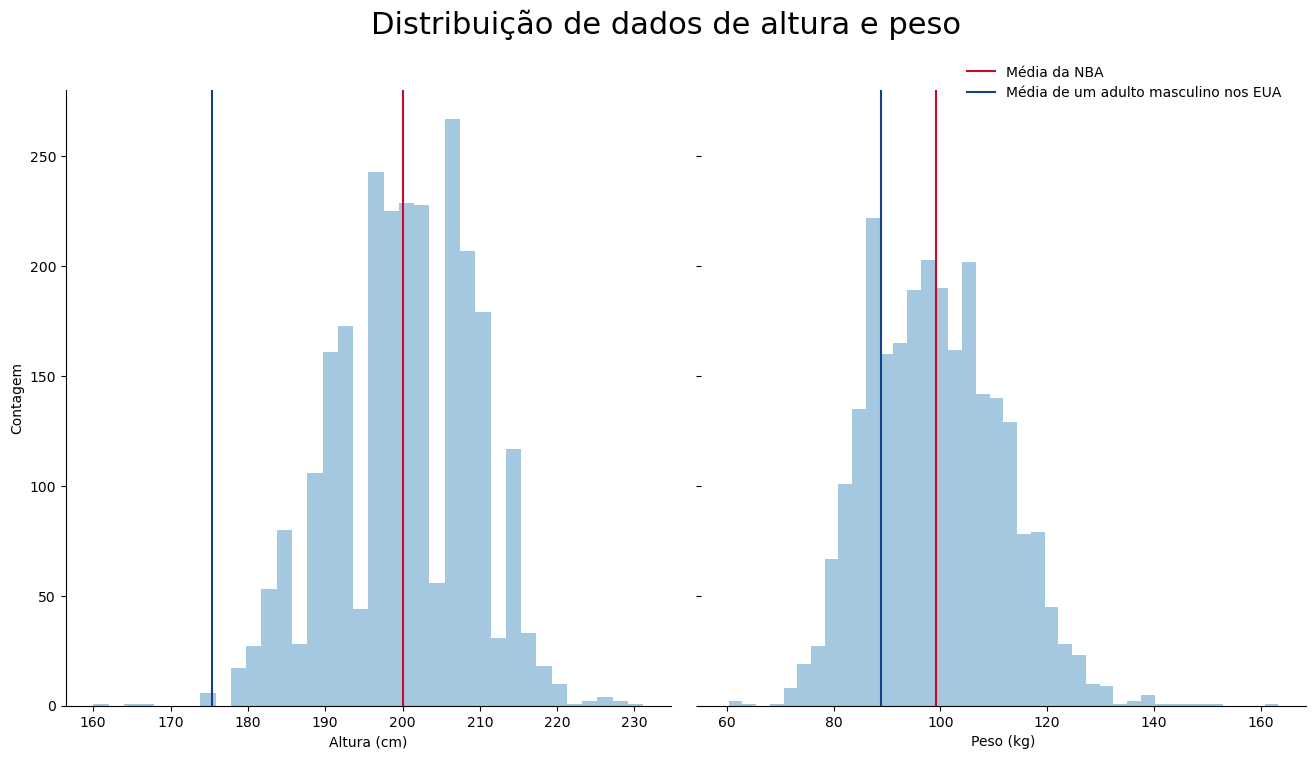

In [80]:
# Visualizando a distribuição de dados de altura e peso
# Fonte para a altura média masculina dos EUA: https://en.wikipedia.org/wiki/Average_human_height_by_country
# Fonte para o peso médio masculino dos EUA:https://en.wikipedia.org/wiki/Human_body_weight

fig, ax = plt.subplots(1,2,figsize=(16, 8),sharey=True)
plt.subplots_adjust(wspace=0.05)

sns.distplot(main_variables ['player_height'], ax=ax[0], label='_nolegend_', kde=False)
sns.distplot(main_variables ['player_weight'], ax=ax[1], label='_nolegend_', kde=False)
ax[0].axvline(main_variables ['player_height'].mean(), color='#c9082a', label='Média da NBA')
ax[1].axvline(main_variables ['player_weight'].mean(), color='#c9082a', label='Média da NBA')

# Add lines for average adults to compare
ax[0].axvline(175.3, color='#17408b', label='Média de um adulto masculino nos EUA')
ax[1].axvline(88.8, color='#17408b', label='Média de um adulto masculino nos EUA')

ax[0].yaxis.set_label_text('Contagem')
ax[0].xaxis.set_label_text('Altura (cm)')
ax[1].xaxis.set_label_text('Peso (kg)')
plt.suptitle('Distribuição de dados de altura e peso', fontsize=22)
plt.legend(loc='upper right', bbox_to_anchor=(0.98, 1.06), frameon=False)
sns.despine(ax=ax[1], left=True)
sns.despine(ax=ax[0])

plt.show()


Ambos, altura e peso, estão distribuídos normalmente na NBA. No entanto, está claro que os atletas da NBA se destacam em termos de altura e peso quando comparados aos homens adultos normais.

In [81]:
fig = go.Figure(data=go.Scatter(x=main_variables['player_weight'],
                                y=main_variables['player_height'],
                                mode='markers',
                                text=main_variables['player_name'],
                                marker=dict(color='#17408b')
                                ))

fig.update_layout(
    title='Altura e peso do jogador da NBA (para exploração interativa)',
    xaxis_title='Peso (kg)',
    yaxis_title='Altura (cm)',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.show()

Esta tabela utiliza a biblioteca de visualização Plotly. Uma grande vantagem de uma tabela Plotly é a capacidade de resposta inerente, sem a necessidade de escrever linhas adicionais de código. Isso permite passar o mouse sobre os pontos de dados e observar:

O jogador mais alto a pisar na quadra da NBA foi Gheorghe Muresan, com 231 cm de altura.
O jogador mais baixo é Muggsy Bogues com 160 cm
Sim Bhullar é de longe o jogador mais pesado, pesando 163 kg (ele também fez história ao ser o primeiro jogador da NBA de ascendência indiana)

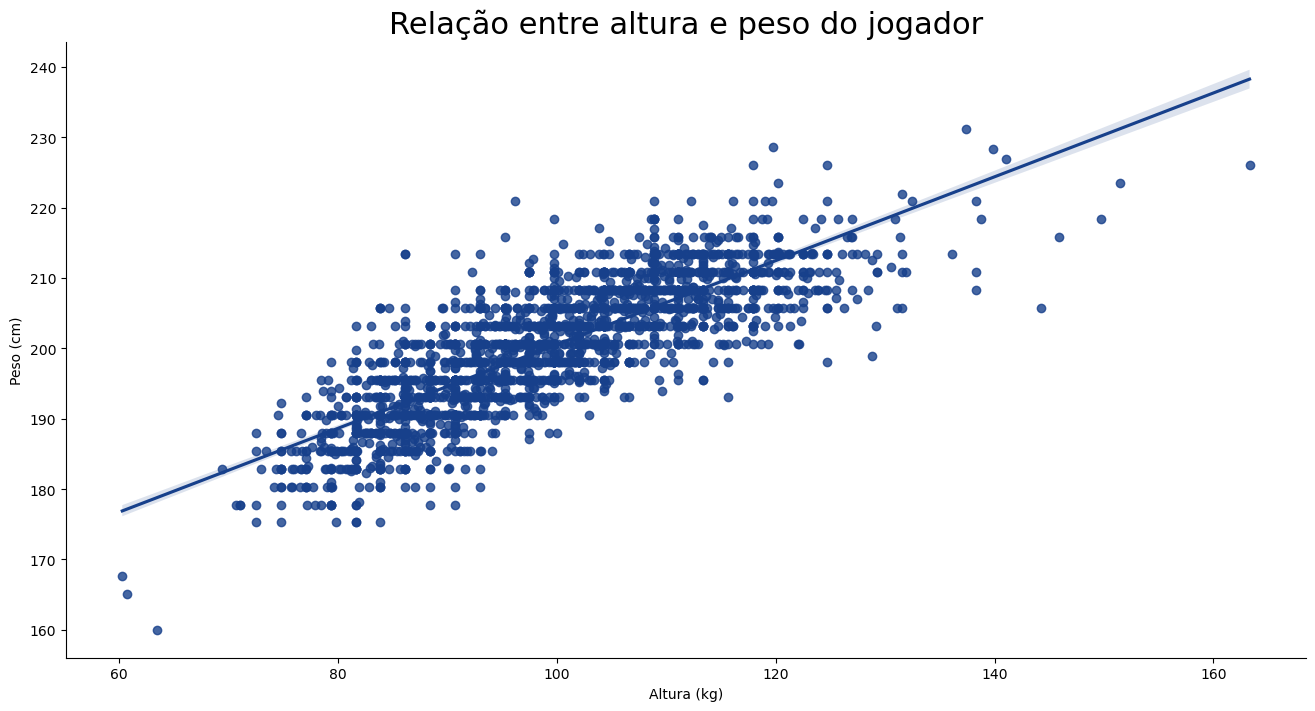

In [82]:
plt.figure(figsize=(16, 8))

sns.regplot(x='player_weight', y='player_height', data=main_variables, color='#17408b')

plt.title('Relação entre altura e peso do jogador', fontsize=22)
plt.ylabel('Peso (cm)')
plt.xlabel('Altura (kg)')
sns.despine()

plt.show()

In [83]:
corr = stats.pearsonr(main_variables['player_height'], main_variables['player_weight'])

print(f"A correlação entre altura e peso do jogador é: {corr[0]}. A significância estatística desta relação é {corr[1]}")


A correlação entre altura e peso do jogador é: 0.8150902497917946. A significância estatística desta relação é 0.0


Não é de surpreender que altura e peso sejam duas variáveis intimamente relacionadas.

In [84]:
corr_over_seasons = df.groupby('season')[['player_weight','player_height']].corr().unstack().iloc[:,1]

fig = go.Figure()
fig.add_trace(go.Scatter(x=corr_over_seasons.index, 
                         y=corr_over_seasons.values,
                         mode='lines',
                         name='lines',
                         line=dict(color='#17408b')
                        ))

fig.update_layout(
    title='Correlação de altura e peso dos jogadores da NBA em cada temporada',
    xaxis_title='Temporada',
    yaxis_title='Correlação',
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()

No entanto, se decompormos a correlação por estação, podemos ver que ela está diminuindo constantemente. Este é um indicador precoce das mudanças no tipo corporal dos jogadores da NBA.

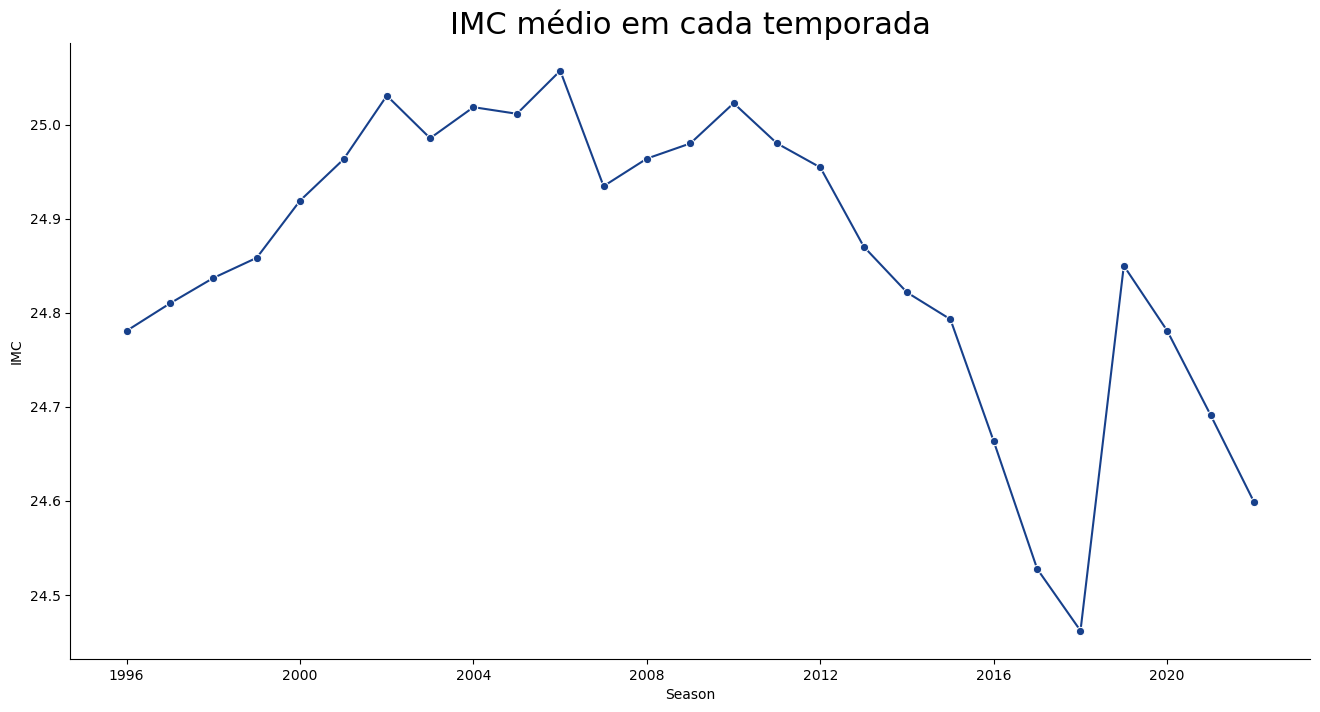

In [85]:
df['bmi'] = df['player_weight'].values / (df['player_height'].values ** 2) * 10000

plt.figure(figsize=(16, 8))

sns.lineplot(x=df['season'], y='bmi', data=df, marker="o", ci=None, color='#17408b')

plt.title('IMC médio em cada temporada', fontsize=22)
plt.ylabel('IMC')
plt.xlabel('Season')
sns.despine()

plt.show()

2019 parece ser um ano atípico na tendência de diminuição do IMC, então vamos explorá-lo com mais detalhes, exibindo os 10 melhores jogadores com o IMC mais alto.

In [86]:
bmi_exploration = df[df['season'] == '2019']
bmi_exploration[['player_name','bmi']].sort_values(by='bmi',ascending=False)[:10]

,player_name,bmi
11029,Zion Williamson,32.82
10667,Jarrell Brantley,29.65
10899,Eric Paschall,29.47
10918,Deonte Burton,29.21
10855,Andre Drummond,29.17
11135,P.J. Tucker,29.05
11120,Paul Millsap,28.95
11014,Wendell Carter Jr.,28.93
10775,Jusuf Nurkic,28.90
10847,Admiral Schofield,28.58


Ahh... o elenco da NBA de 2019 tem alguns jogadores acima do peso, com este homem liderando o ataque:: ![Zian double biceps](https://phantom-marca.unidadeditorial.es/4964b78f45ed84da95c39bdb7e80cefb/resize/828/f/jpg/assets/multimedia/imagenes/2023/07/12/16891488229944.jpg)

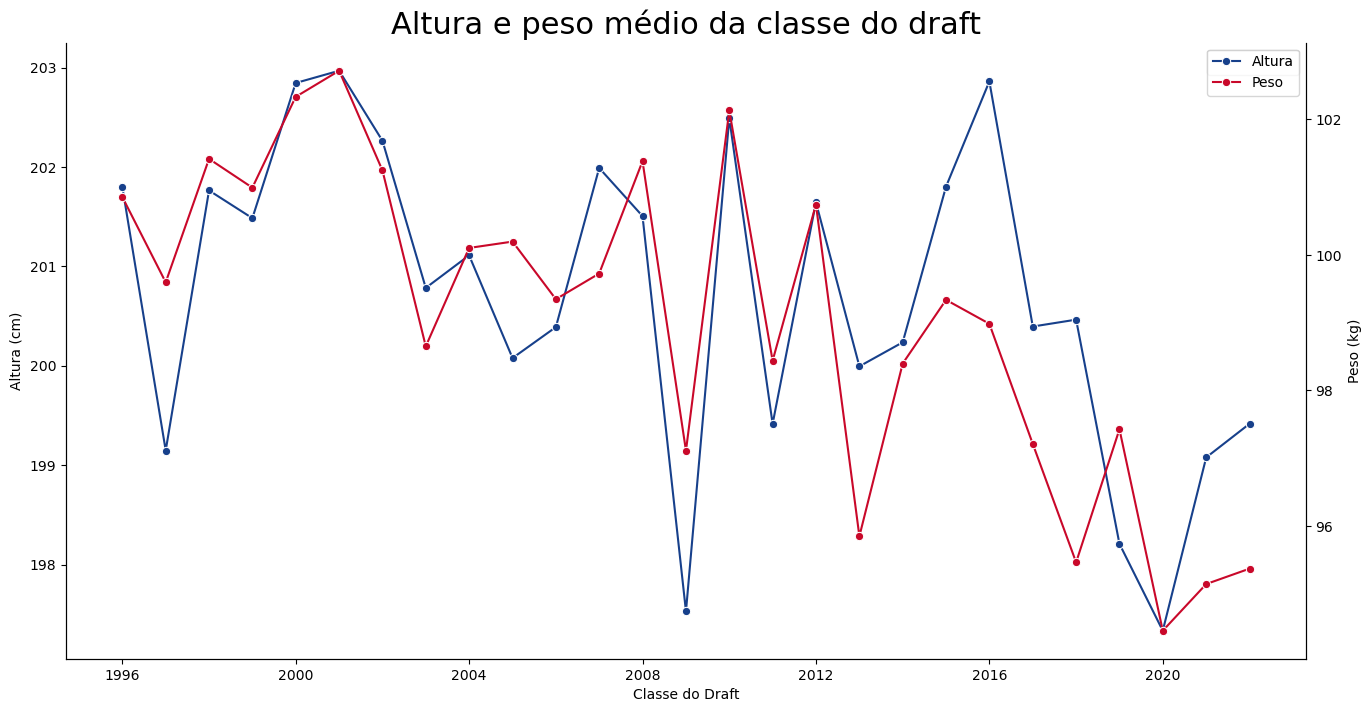

In [87]:
first_season_drafted = df.query('season == draft_year')

h_w_by_draft_year = first_season_drafted.groupby('draft_year')[['player_height', 'player_weight']].mean()

fig, ax = plt.subplots(figsize=(16, 8))
ax2 = ax.twinx()

sns.lineplot(x=h_w_by_draft_year.index, y='player_height', data=h_w_by_draft_year, marker="o", ax=ax, ci=None, label='Altura', color='#17408b')
sns.lineplot(x=h_w_by_draft_year.index, y='player_weight', data=h_w_by_draft_year, marker="o", ax=ax2, ci=None, label='Peso', color='#c9082a')

plt.title('Altura e peso médio da classe do draft', fontsize=22)
ax.xaxis.set_label_text('Classe do Draft')
ax.yaxis.set_label_text('Altura (cm)')
ax2.yaxis.set_label_text('Peso (kg)')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.show()

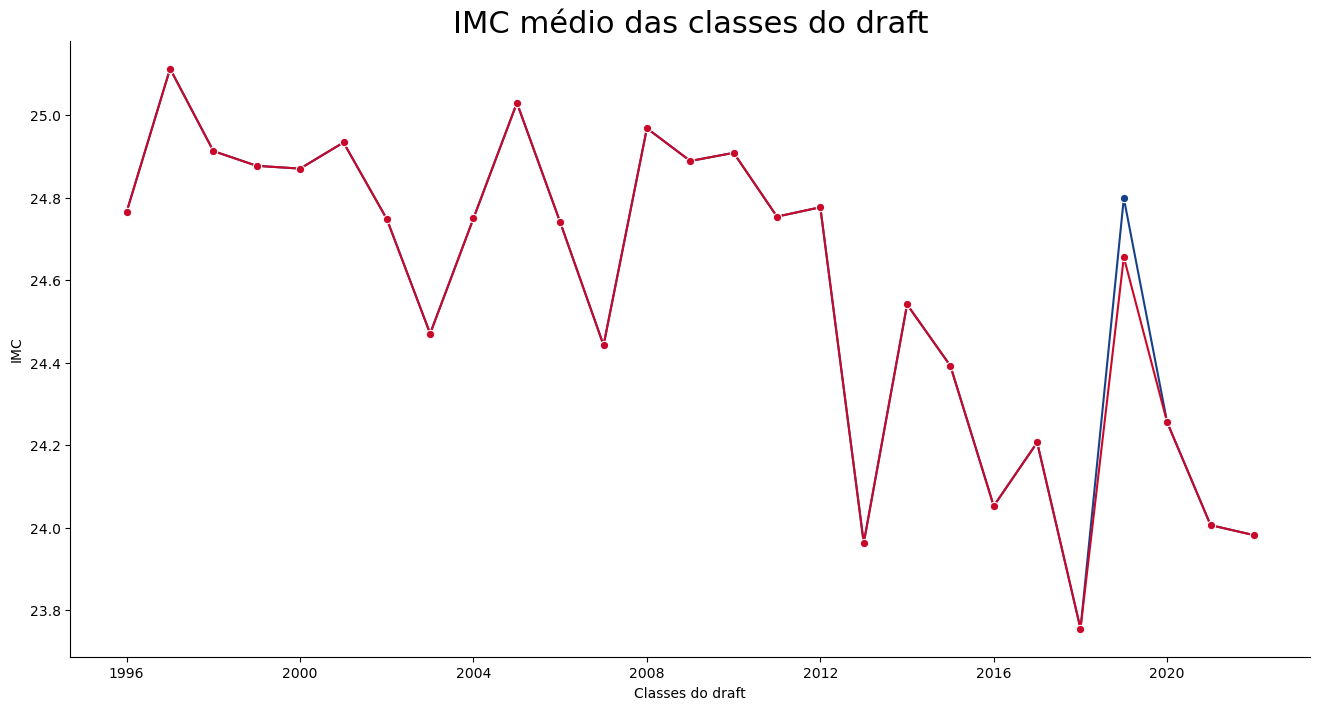

In [88]:
bmi_draft = h_w_by_draft_year['player_weight'] / (h_w_by_draft_year['player_height'] ** 2) * 10000
bmi_draft = pd.DataFrame(bmi_draft, columns=['bmi'])

first_season_drafted_nz = first_season_drafted[first_season_drafted['player_name'] != 'Zion Williamson']
h_w_by_draft_year_nz = first_season_drafted_nz.groupby('draft_year').agg({'player_height': 'mean', 'player_weight': 'mean'})
bmi_draft_nz = h_w_by_draft_year_nz['player_weight'] / (h_w_by_draft_year_nz['player_height'] ** 2) * 10000
bmi_draft_nz = pd.DataFrame(bmi_draft_nz, columns=['bmi'])

plt.figure(figsize=(16, 8))

sns.lineplot(x=bmi_draft.index, y=bmi_draft['bmi'], data=bmi_draft, marker="o", color='#17408b')
sns.lineplot(x=bmi_draft_nz.index, y=bmi_draft_nz['bmi'], data=bmi_draft, marker="o", color='#c9082a')

plt.title('IMC médio das classes do draft', fontsize=22)
plt.ylabel('IMC')
plt.xlabel('Classes do draft')
sns.despine()

plt.show()

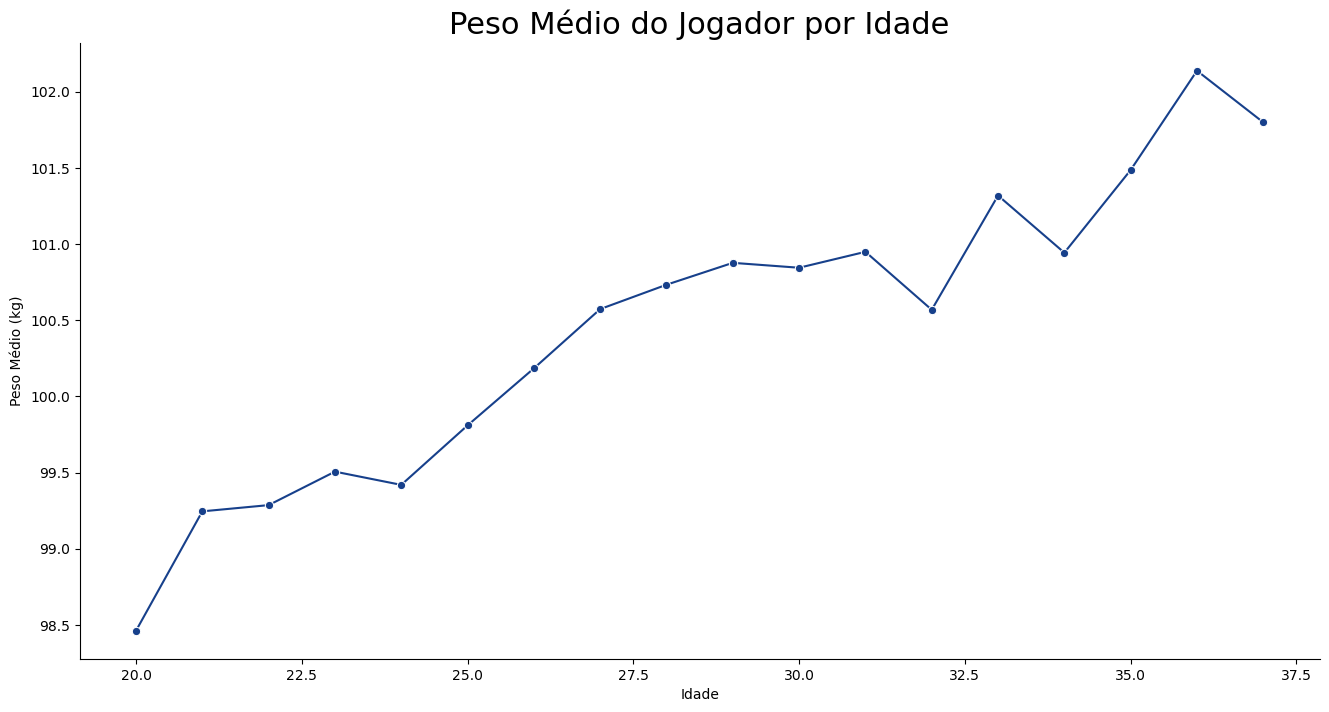

In [89]:
plt.figure(figsize=(16, 8))

w_by_age = df.groupby(['age'])['player_weight'].agg(['mean', 'count'])
w_by_age['outliers'] = np.where(w_by_age['count']<=100, 1, 0)
w_by_age = w_by_age.loc[w_by_age['outliers']==0]

sns.lineplot(x=w_by_age.index, y='mean', data=w_by_age, marker='o', color='#17408b')

plt.title('Peso Médio do Jogador por Idade', fontsize=22)
plt.ylabel('Peso Médio (kg)')
plt.xlabel('Idade')
sns.despine()

plt.show()


## Medidas e Localização

In [90]:
# Selecionando a altura e o peso do jogador quando ele entrou na liga
relevant_fields = df[['player_name', 'player_height', 'player_weight', 'country', 'season']]
player_first_season = relevant_fields.loc[relevant_fields.groupby(['player_name']).season.idxmin()]

# Agrupando por país e contando o número de jogadores de cada país
df_geography = player_first_season.groupby('country', as_index=False).agg(
                                                                          {'player_height': 'mean', 'player_weight':'mean', 'player_name':'count'}
                                                                          ).rename({'player_name': 'count'}, axis=1) 

# Selecionando países que tenham pelo menos três jogadores
df_geography = df_geography[df_geography['count'] >= 3]

# Adicionando códigos de país para visualização Plotly
df_geography = pd.merge(df_geography, country_codes, how='inner', on='country')

In [91]:
height_map = go.Choropleth(
    locations = df_geography['code_3digit'],
    z = df_geography['player_height'],
    text = df_geography['country'],
    colorscale = 'Blues',
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Altura do Jogador (cm)'
)

weight_map = go.Choropleth(
    locations = df_geography['code_3digit'],
    z = df_geography['player_weight'],
    text = df_geography['country'],
    colorscale = 'Blues',
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Peso do Jogador (kg)',
    visible=False
)

data = [height_map, weight_map]

updatemenus = list([
    dict(type="buttons",
         y=0.7,
         buttons=list([   
            dict(label = 'Mapa de altura',
                 method = 'update',
                 args = [{'visible': [True, False]},
                         {'title': 'Altura média dos jogadores da NBA por país'}]),

            dict(label = 'Mapa de peso',
                 method = 'update',
                 args = [{'visible': [False, True]},
                         {'title': 'Peso médio do jogador da NBA por país'}])
        ]),
    )
])

layout = dict(updatemenus=updatemenus,
             title_text='Altura média dos jogadores da NBA por país',
             geo=dict(
                showframe=False,
                showcoastlines=False,
                projection_type='equirectangular'),
             margin=dict(l=0, r=0, b=0),
             height=500
             )

fig = dict(data=data, layout=layout)

plotly.offline.iplot(fig)


A visualização acima mostra a altura e o peso médios dos jogadores (mínimo de 3 jogadores únicos) com base no país em que nasceram (ou têm cidadania).

## Impacto da altura e do peso no desempenho

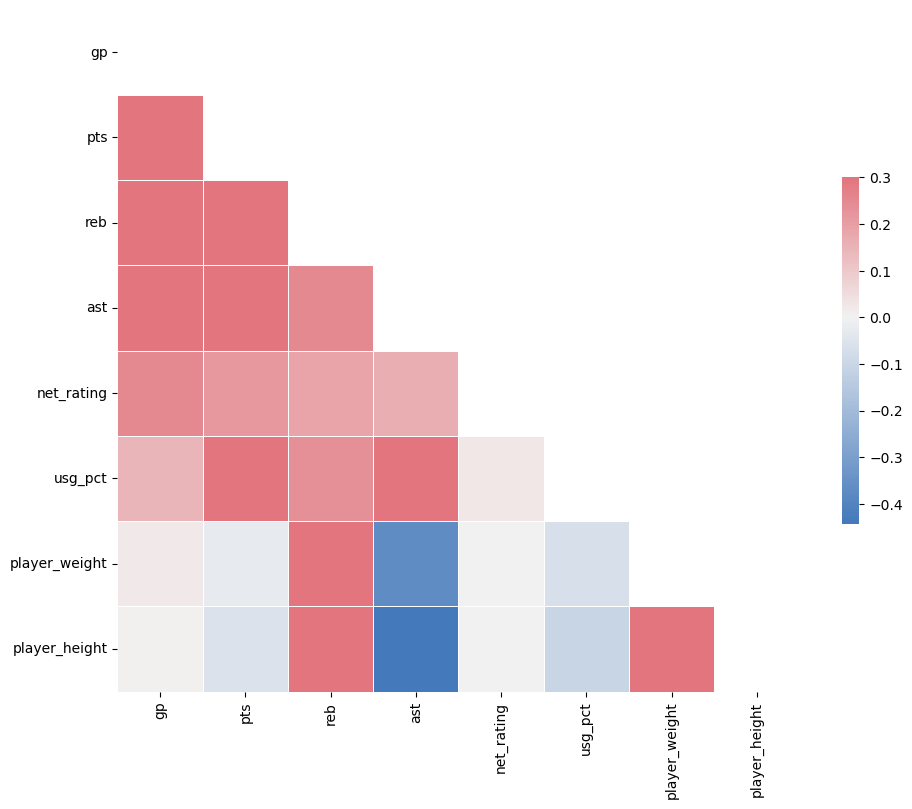

In [92]:
df_corr = df[df['season'] != '2019-01-01']
df_corr = df[['gp','pts','reb','ast','net_rating','usg_pct','player_weight', 'player_height']]

# Calculando a matriz de correlação
corr = df_corr.corr()

# Gerando uma máscara para o triângulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurando matplotlib
f, ax = plt.subplots(figsize=(11, 9))

# Gerando um mapa de cores divergente personalizado
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# Desenhando o mapa de calor com a máscara e a proporção correta
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

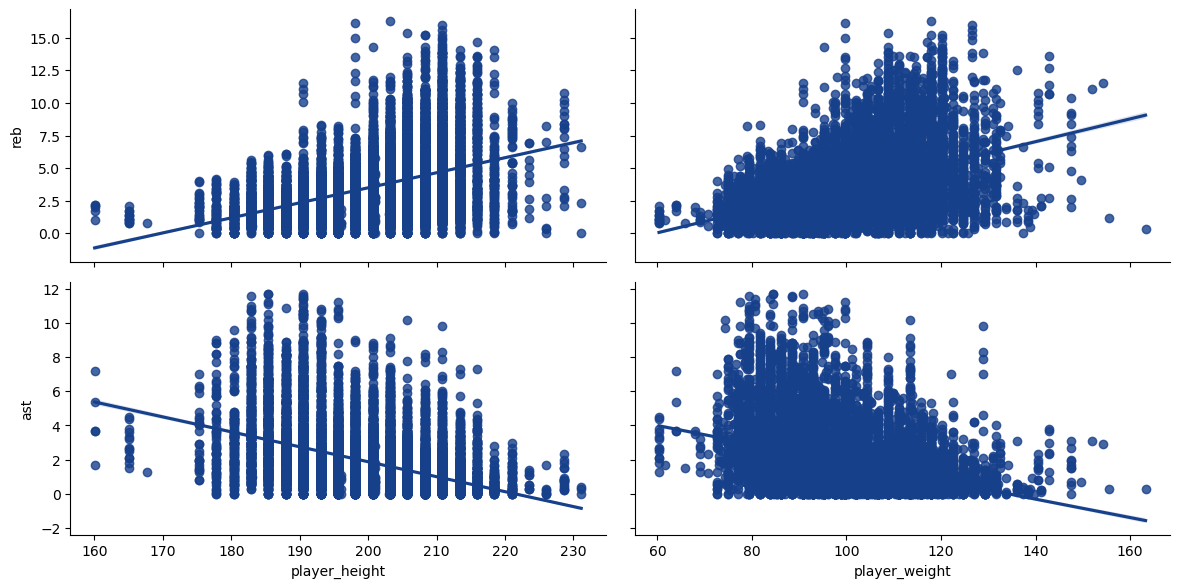

In [93]:
g = sns.PairGrid(df_corr, y_vars=['reb','ast'], x_vars=["player_height", "player_weight"], height=3, aspect=2)
g.map(sns.regplot, color='#17408b')
plt.show()

Nem a altura nem o peso parecem ter impacto significativo no total de jogos disputados e na média de pontos marcados. No entanto, como esperado, a altura e o peso impactam as estatísticas médias de assistência e recuperação.

In [94]:
corr_w_r = df.groupby('season')[['player_weight','reb']].corr().unstack().iloc[:,1]
corr_w_a = df.groupby('season')[['player_weight','ast']].corr().unstack().iloc[:,1]

corr_h_r = df.groupby('season')[['player_height','reb']].corr().unstack().iloc[:,1]
corr_h_a = df.groupby('season')[['player_height','ast']].corr().unstack().iloc[:,1]

In [95]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=corr_w_r.index, y=corr_w_r.values,
                    mode='lines',
                    name='Peso e Rebotes'))

fig.add_trace(go.Scatter(x=corr_w_a.index, y=corr_w_a.values,
                    mode='lines',
                    name='Peso e Assistências'))

fig.add_trace(go.Scatter(x=corr_h_r.index, y=corr_h_r.values,
                    mode='lines',
                    name='Altura e Rebotes'))

fig.add_trace(go.Scatter(x=corr_h_a.index, y=corr_h_a.values,
                    mode='lines',
                    name='Altura e Assistências'))

fig.update_layout(
    title='Comparação do coeficiente de correlação ao longo do tempo',
    xaxis_title='Temporada',
    yaxis_title='Coeficiente',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.show()

Os coeficientes de recuperação são estáveis. No entanto, a correlação negativa para assistências (quanto mais alto ou mais pesado é o jogador, menos assistências ele dá) tem vindo a diminuir desde 2011. Isto ilustra como o jogo está a mudar e os grandes estão a tornar-se mais integrantes na jogabilidade geral da equipe.

## Transformações de peso

In [99]:
# Largest body weigth transformations

# Compute weight percentage change values for each player by age
w_pct_change = df.groupby(['season', 'player_name'], as_index=False)['player_weight'].mean().sort_values(['player_name', 'season'])
w_pct_change_values = w_pct_change.groupby(['player_name'])['player_weight'].apply(lambda x: x.pct_change())
w_pct_change = pd.concat([w_pct_change, w_pct_change_values], axis=1).fillna(0)
w_pct_change.columns = ['season', 'player_name', 'weight', 'pct_change']

counts = w_pct_change['player_name'].value_counts()
w_pct_change = w_pct_change[w_pct_change['player_name'].isin(counts.index[counts > 5])]

w_pct_change['sig_cng'] = np.where((w_pct_change.groupby('player_name')['pct_change'].transform('max') > 0.15) | (w_pct_change.groupby('player_name')['pct_change'].transform('min') < -0.15), 1, 0)

In [97]:
a = w_pct_change[w_pct_change['sig_cng'] == 1]

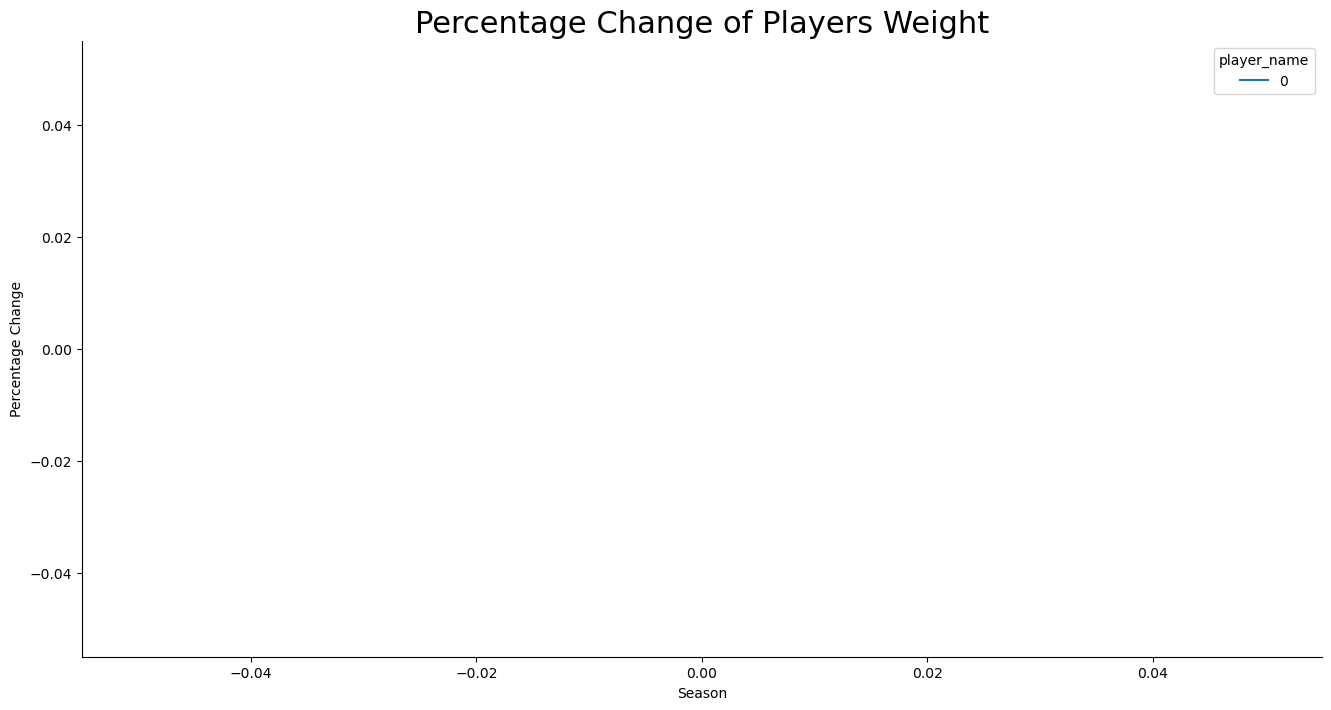

In [98]:
plt.figure(figsize=(16, 8))

sns.lineplot(x="season", y="weight", data=a, units='player_name', estimator=None, hue='player_name')

plt.title('Percentage Change of Players Weight', fontsize=22)
plt.ylabel('Percentage Change')
plt.xlabel('Season')
sns.despine()

plt.show()